In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting celiib@10.28.0.34:3306


In [20]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
ndap100 = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
pinky_fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')

schema = dj.schema("microns_pinky_radtune")


# Direction Connection Orientation Scatter Plot

In [3]:
"""
Purpose: 8/15/19
Going to get a table of the significant tuned segment combinations with Somas
And then plot the pairs orientation as a scatter plot

Then going to highlight the ones in red that have a direct connection

"""

'\nPurpose: 8/15/19\nGoing to get a table of the significant tuned segment combinations with Somas\nAnd then plot the pairs orientation as a scatter plot\n\nThen going to highlight the ones in red that have a direct connection\n\n'

In [4]:
# Exclude synapses, segments and restrict by functional confidence 

synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation

soma = soma & "cell_class='excitatory'"

In [5]:
"""
Gets the combination and their unidirection number of synapses between them
"""

# number of direct connections (synapses) for each functional soma pair (both presyn and postsyn are somas with functional traces)

#gets all of the synapses where the presyn and postsyn are both soma cells
fun_fun_syn = synapse & soma.proj(presyn = 'segment_id') & soma.proj(postsyn = 'segment_id') 
#adds up the number of synapses for each soma-soma combination (some wont have a combination because not have synapse between them)
n_syn = dj.U('presyn', 'postsyn').aggr(fun_fun_syn, n_syn = 'count(*)') # soma-soma pairs with at least one synapse
soma_no_id = dj.U("segmentation","segment_id") & soma
#gets all the possible combinations of soma to soma where they aren't the same segment
all_fun_fun = soma_no_id.proj(presyn = 'segment_id') * soma_no_id.proj(postsyn = 'segment_id') & 'presyn != postsyn'
#makes a generic table for all soma combinations that assymes no synapses between them
rel = (dj.U('presyn', 'postsyn') & all_fun_fun).proj('presyn', 'postsyn', n_syn='0')
#combines the base generic 0 synapse table with the one with actual values
#rel is the base table and they are adding the synapse table to it
total_n_syn = rel.aggr(dj.U('n_add') * n_syn.proj(n_add='n_syn'), n_syn_total='n_syn + ifnull(n_add, 0)', keep_all_rows=True)# fill out all zeros

"""
if made n x n combination box with presyns on x and postsyns on y 
a (where presyn < postsyn) is the top right traingle
b (presyn > postsyn) is bottom right triangle

We want every combination of A --> B added together
A (presyn) to B (postsyn) + B (presyn) to A (postsyn)
"""

#combine a-b and b-a connections into one number, and segment_id1 < segment_id2
attrs = ['presyn', 'postsyn', 'n_syn_total']
a = (total_n_syn & 'presyn < postsyn').proj('presyn', 'postsyn', n_syn1 = 'n_syn_total')
b = (total_n_syn & 'presyn > postsyn').proj(n_syn2 = 'n_syn_total', postsyn = 'presyn', presyn = 'postsyn')

"""adds up the non-directional number of synapses for A --> B and B --> A
## *** can use projections to rename primary keys ***
Uses table a as the base table so that is where presyn is less than the postsyn

"""

undirected_n_syn = (a * b).proj(n_syn_total = 'n_syn1 + n_syn2', segment_id1 = 'presyn', segment_id2 = 'postsyn')
undirected_n_syn




segment_id1 segment id unique within each Segmentation,segment_id2 segment id unique within each Segmentation,n_syn_total calculated attribute
648518346341371119,648518346349386137,0
648518346341371119,648518346349470171,0
648518346341371119,648518346349471156,0
648518346341371119,648518346349471500,0
648518346341371119,648518346349471562,0
648518346341371119,648518346349471565,1
648518346341371119,648518346349471910,0
648518346341371119,648518346349472574,0
648518346341371119,648518346349472601,0
648518346341371119,648518346349473044,0


In [6]:
ex_key = dict(segment_id=648518346341351894,segmentation=3)

vonfit_data = (radtune.BestVonFit.Unit & ex_key).fetch1()
vonfit_data

OrderedDict([('segmentation', 3),
             ('vonbestfit_method', 1),
             ('segment_id', 648518346341351894),
             ('von_hash', '3975d5cb0692a185ecb12767aef38fda'),
             ('base', 0.00608233),
             ('thetas', array([0.99976149, 4.14135415])),
             ('amps', array([0.09545269, 0.04130358])),
             ('sharps', array([22.08464569, 22.08464569])),
             ('flat_pred', 0.0174556),
             ('von_pred', 0.0169626),
             ('shuff_pred', 0.0171703),
             ('von_pred_adv', 0.0118989),
             ('von_p_value', 0.128),
             ('confidence', 1.2574478737658663)])

In [7]:
0.99976149*180/np.pi,4.14135415*180/np.pi,0.99976149*180/np.pi + 180

(57.28211389671066, 237.28211426398843, 237.28211389671065)

In [9]:
seg_ids,thetas,amps = (radtune.BestVonFit.Unit & soma.proj()).fetch("segment_id","thetas","amps")

In [10]:
for identity,theta,amp in zip(seg_ids,thetas,amps):
    if amp[0] <= amp[1]:
        print(identity)
        print("Amp less than")
        print(amp)

648518346349490614
Amp less than
[0. 0.]


# Conclusion: shows that need to add more filters to the significant figures

In [11]:
@schema
class BestVonFit(dj.Computed):
    definition = """
    # Mean responses to radially coherent stimuli
    -> pinky.Segmentation
    -> VonBestFitMethod
    ---
    """

    class Unit(dj.Part):
        definition = """
        -> master
        -> pinky.Segment
        ---
        -> VonHash
        base                     : float                # von mises baseline amplitude
        thetas                   : blob                 # von mises gaussian peak angle (descending amp order)
        amps                     : blob                 # von mises gaussian amplitudes (descending amp order)
        sharps                   : blob                 # von mises gaussian sharpness (descending amp order)
        flat_pred                : float                # predictive performance of flat mean
        von_pred                 : float                # predictive performance of von fit on unshuffled data
        shuff_pred               : float                # predictive performance of von fit on shuffled data
        von_pred_adv             : float                # von mises predictive advantage over shuffled data
        von_p_value              : float                # fit component p_value by reshuffle
        confidence               : double               # confidence value that neuron is good match
        """

    @classmethod
    def get_sig_bestvon(cls, fdve_thresh=None, fve_thresh=None,
                        p_thresh=0.002, vonbestfit_method=1,
                        conf_thresh=1, exclude=True):

        von_rest = (f'vonbestfit_method = {vonbestfit_method} and confidence > {conf_thresh}')

        if fdve_thresh:
            von_rest = von_rest + f' and von_pred_adv > {fdve_thresh}'
        if fve_thresh:
            von_rest = von_rest + f' and von_pred > {fve_thresh}'
        if p_thresh:
            von_rest = von_rest + f' and von_p_value < {p_thresh}'
        sig_rel = ((cls.Unit & von_rest) & pinky.CurrentSegmentation)
        if exclude:
            sig_rel = sig_rel - pinky.SegmentExclude
        return sig_rel

In [25]:
sig_relations_best_von = BestVonFit.get_sig_bestvon(conf_thresh=0.5)
sig_relations_best_von

segmentation segmentation id,vonbestfit_method method index,segment_id segment id unique within each Segmentation,von_hash unique hash for combination of sta analysis methods,base von mises baseline amplitude,thetas von mises gaussian peak angle (descending amp order),amps von mises gaussian amplitudes (descending amp order),sharps von mises gaussian sharpness (descending amp order),flat_pred predictive performance of flat mean,von_pred predictive performance of von fit on unshuffled data,shuff_pred predictive performance of von fit on shuffled data,von_pred_adv von mises predictive advantage over shuffled data,von_p_value fit component p_value by reshuffle,confidence confidence value that neuron is good match
3,1,648518346341356241,66dc6420ca132a85ddda25939f084caa,0.00565237,=BLOB=,=BLOB=,=BLOB=,0.0202752,0.0178552,0.0200274,0.107137,0.001,0.957373658926309
3,1,648518346341356256,73dbecb8885beae030be3c263406f897,0.025249,=BLOB=,=BLOB=,=BLOB=,0.0679271,0.063242,0.0669904,0.0551834,0.001,1.7858262119801065
3,1,648518346341359123,8e54b140337daf69dfda4e9fbe14ae7f,0.0297197,=BLOB=,=BLOB=,=BLOB=,0.141441,0.122979,0.139556,0.117201,0.001,3.708831526488791
3,1,648518346341361981,f0c077c6b3ec8074c419a09fbb23388b,0.00287949,=BLOB=,=BLOB=,=BLOB=,0.0234285,0.0217913,0.0229093,0.0477177,0.001,1.4644267171718275
3,1,648518346341362771,a7d6d9bb9c79de84f8792c46b1516c16,0.047481,=BLOB=,=BLOB=,=BLOB=,0.681801,0.587579,0.668815,0.119148,0.001,0.6869009007690088
3,1,648518346341369370,8e4dd43ab0a7846e5013ecc6025e9acc,0.0193596,=BLOB=,=BLOB=,=BLOB=,0.234322,0.210452,0.230954,0.087497,0.001,0.5961253447331519
3,1,648518346341379312,8f3db7b9d61c1c8458fe115a339c7b86,0.000641483,=BLOB=,=BLOB=,=BLOB=,0.0427635,0.0370261,0.0422116,0.12126,0.001,0.5843029464358273
3,1,648518346341380208,74e215bae05c675a123732aa45a53b69,0.00306518,=BLOB=,=BLOB=,=BLOB=,0.0916323,0.0823298,0.0903508,0.0875341,0.001,0.5335169346113676
3,1,648518346341385331,96d93eb2895fe58e287a514e0f83940d,0.00550576,=BLOB=,=BLOB=,=BLOB=,0.10177,0.0808544,0.100497,0.193006,0.001,0.6286509538088302
3,1,648518346341389643,b09b0148ef83ed2d83aa1983c6c919bb,0.00926537,=BLOB=,=BLOB=,=BLOB=,0.046643,0.0414749,0.0460076,0.0971797,0.001,1.3243637575452651


In [13]:
seg_ids,thetas,amps = (sig_relations_best_von & soma.proj()).fetch("segment_id","thetas","amps")
for identity,theta,amp in zip(seg_ids,thetas,amps):
    if amp[0] <= amp[1]:
        print(identity)
        print("Amp less than")
        print(amp)

In [14]:
len(seg_ids)

42

In [15]:
"""This is what the significant function returns"""
radtune.BestVonFit.Unit() & soma.proj() & 'von_p_value <= 0.002' & "confidence>0.5"

segmentation segmentation id,vonbestfit_method method index,segment_id segment id unique within each Segmentation,von_hash unique hash for combination of sta analysis methods,base von mises baseline amplitude,thetas von mises gaussian peak angle (descending amp order),amps von mises gaussian amplitudes (descending amp order),sharps von mises gaussian sharpness (descending amp order),flat_pred predictive performance of flat mean,von_pred predictive performance of von fit on unshuffled data,shuff_pred predictive performance of von fit on shuffled data,von_pred_adv von mises predictive advantage over shuffled data,von_p_value fit component p_value by reshuffle,confidence confidence value that neuron is good match
3,1,648518346349470171,104cb5878f833fe425a0ee7750d69024,0.0338352,=BLOB=,=BLOB=,=BLOB=,1.97013,1.4807,1.94225,0.234276,0.001,3.365524540011297
3,1,648518346349471565,ea7d60f34fe148d38a772c45ffd9d8d2,0.0,=BLOB=,=BLOB=,=BLOB=,13.4957,7.61779,13.3783,0.42684,0.001,3.1366678362873084
3,1,648518346349472574,121f62f7bfd521edb32dcd89bc0e696b,0.00707987,=BLOB=,=BLOB=,=BLOB=,0.0117504,0.0107282,0.0115648,0.0711946,0.001,1.26700343150085
3,1,648518346349473833,8bb981b069c568955229b118039acae2,0.0,=BLOB=,=BLOB=,=BLOB=,6.72941,3.24852,6.65339,0.505969,0.001,2.627829104732558
3,1,648518346349475536,4e1a88968fc9c4fd63b99635861b8291,0.0239916,=BLOB=,=BLOB=,=BLOB=,0.399129,0.344868,0.393501,0.121848,0.001,2.9011142670377916
3,1,648518346349475573,acc70407cc0825b60a383220645cfad3,0.0,=BLOB=,=BLOB=,=BLOB=,0.195326,0.179368,0.192504,0.0672496,0.001,1.4479411512793823
3,1,648518346349482312,179cf4d8a3038c2320b9e000437c78f3,0.0,=BLOB=,=BLOB=,=BLOB=,0.897127,0.813767,0.88305,0.0772273,0.001,2.512158028028598
3,1,648518346349483124,9916df1ccda2f731198b80dc2a43fb43,0.0849652,=BLOB=,=BLOB=,=BLOB=,8.49383,5.56615,8.38582,0.331967,0.001,3.4279893572594107
3,1,648518346349488659,f7978bf93ae7d47941bef9ca9d26145f,0.0160907,=BLOB=,=BLOB=,=BLOB=,0.0216602,0.0201383,0.0213385,0.055407,0.001,0.5864772576750952
3,1,648518346349491811,449763d90b8a0bb06dde845df8f35af3,0.0181213,=BLOB=,=BLOB=,=BLOB=,0.315991,0.240614,0.312157,0.226407,0.001,2.9586540477492376


# Start of making Orientation vs Orientation graph

In [16]:
undirected_n_syn

segment_id1 segment id unique within each Segmentation,segment_id2 segment id unique within each Segmentation,n_syn_total calculated attribute
648518346341371119,648518346349386137,0
648518346341371119,648518346349470171,0
648518346341371119,648518346349471156,0
648518346341371119,648518346349471500,0
648518346341371119,648518346349471562,0
648518346341371119,648518346349471565,1
648518346341371119,648518346349471910,0
648518346341371119,648518346349472574,0
648518346341371119,648518346349472601,0
648518346341371119,648518346349473044,0


In [17]:
"""
Pseudo-code: 
1) Restrict the synapse table by the neurons that have significant directional tuning
2) Pull down the segment_ids and number of synapses for those tables
3) Pull down the thetas and extract the orientation for each of the segments and store in a dictionary
4) Use orientation dictionary to construct parallel array for orientation 
tuples of each combination in restricted synapse table pulled down
5) Find the total number of possibilities for the number of synapses (see if can bin them into groups)
6) do a scatter plot graph with the different bins of the number of synapses

"""

'\nPseudo-code: \n1) Restrict the synapse table by the neurons that have significant directional tuning\n2) Pull down the segment_ids and number of synapses for those tables\n3) Pull down the thetas and extract the orientation for each of the segments and store in a dictionary\n4) Use orientation dictionary to construct parallel array for orientation \ntuples of each combination in restricted synapse table pulled down\n5) Find the total number of possibilities for the number of synapses (see if can bin them into groups)\n6) do a scatter plot graph with the different bins of the number of synapses\n\n'

In [26]:
sig_relations_best_von = BestVonFit.get_sig_bestvon(conf_thresh=0.5)
sig_relations_best_von_soma = sig_relations_best_von & soma.proj()
sig_relations_best_von_soma

segmentation segmentation id,vonbestfit_method method index,segment_id segment id unique within each Segmentation,von_hash unique hash for combination of sta analysis methods,base von mises baseline amplitude,thetas von mises gaussian peak angle (descending amp order),amps von mises gaussian amplitudes (descending amp order),sharps von mises gaussian sharpness (descending amp order),flat_pred predictive performance of flat mean,von_pred predictive performance of von fit on unshuffled data,shuff_pred predictive performance of von fit on shuffled data,von_pred_adv von mises predictive advantage over shuffled data,von_p_value fit component p_value by reshuffle,confidence confidence value that neuron is good match
3,1,648518346349470171,104cb5878f833fe425a0ee7750d69024,0.0338352,=BLOB=,=BLOB=,=BLOB=,1.97013,1.4807,1.94225,0.234276,0.001,3.365524540011297
3,1,648518346349471565,ea7d60f34fe148d38a772c45ffd9d8d2,0.0,=BLOB=,=BLOB=,=BLOB=,13.4957,7.61779,13.3783,0.42684,0.001,3.1366678362873084
3,1,648518346349472574,121f62f7bfd521edb32dcd89bc0e696b,0.00707987,=BLOB=,=BLOB=,=BLOB=,0.0117504,0.0107282,0.0115648,0.0711946,0.001,1.26700343150085
3,1,648518346349473833,8bb981b069c568955229b118039acae2,0.0,=BLOB=,=BLOB=,=BLOB=,6.72941,3.24852,6.65339,0.505969,0.001,2.627829104732558
3,1,648518346349475536,4e1a88968fc9c4fd63b99635861b8291,0.0239916,=BLOB=,=BLOB=,=BLOB=,0.399129,0.344868,0.393501,0.121848,0.001,2.9011142670377916
3,1,648518346349475573,acc70407cc0825b60a383220645cfad3,0.0,=BLOB=,=BLOB=,=BLOB=,0.195326,0.179368,0.192504,0.0672496,0.001,1.4479411512793823
3,1,648518346349482312,179cf4d8a3038c2320b9e000437c78f3,0.0,=BLOB=,=BLOB=,=BLOB=,0.897127,0.813767,0.88305,0.0772273,0.001,2.512158028028598
3,1,648518346349483124,9916df1ccda2f731198b80dc2a43fb43,0.0849652,=BLOB=,=BLOB=,=BLOB=,8.49383,5.56615,8.38582,0.331967,0.001,3.4279893572594107
3,1,648518346349488659,f7978bf93ae7d47941bef9ca9d26145f,0.0160907,=BLOB=,=BLOB=,=BLOB=,0.0216602,0.0201383,0.0213385,0.055407,0.001,0.5864772576750952
3,1,648518346349491811,449763d90b8a0bb06dde845df8f35af3,0.0181213,=BLOB=,=BLOB=,=BLOB=,0.315991,0.240614,0.312157,0.226407,0.001,2.9586540477492376


In [28]:
(42*42 - 42)/2

861.0

In [32]:
shared_input_filtered = pinky_fc.SharedInput() & sig_relations_best_von_soma.proj() & sig_relations_best_von_soma.proj(segment_b="segment_id")
shared_input_filtered

segmentation segmentation id,segment_id segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,n_syn_a number of synapses for cell A,n_syn_b number of synapses for cell B,n_syn_union number of unique synapses for both,n_syn_shared number of shared synapses,n_seg_a number of segments for cell A,n_seg_b number of segments for cell B,n_seg_union number of unique segments for both,n_seg_shared number of shared segments
3,648518346349470171,648518346349471565,742,1873,2586,29,633,1625,2238,20
3,648518346349470171,648518346349472574,742,1362,2019,85,633,1194,1774,53
3,648518346349471565,648518346349472574,1873,1362,3172,63,1625,1194,2766,53
3,648518346349470171,648518346349473833,742,396,1125,13,633,365,988,10
3,648518346349471565,648518346349473833,1873,396,2257,12,1625,365,1980,10
3,648518346349472574,648518346349473833,1362,396,1732,26,1194,365,1537,22
3,648518346349470171,648518346349475536,742,1176,1884,34,633,1035,1642,26
3,648518346349471565,648518346349475536,1873,1176,3000,49,1625,1035,2618,42
3,648518346349472574,648518346349475536,1362,1176,2417,121,1194,1035,2154,75
3,648518346349473833,648518346349475536,396,1176,1562,10,365,1035,1393,7


In [33]:
#Step 2: pulling down the filtered segments and the number of synapses
seg_1, seg_2, n_seg_shared = shared_input_filtered.fetch("segment_id","segment_b","n_seg_shared")

In [34]:
#Step 3:Pull down the thetas and extract the orientation for each of the segments and store in a dictionary
#Step 4: Use orientation dictionary to construct parallel array for orientation  
sig_relations_best_von_soma
seg_ids,thetas,amps = (sig_relations_best_von_soma & soma.proj()).fetch("segment_id","thetas","amps")



In [35]:
thetas

array([array([5.41870079, 2.27710814]), array([2.98199327, 6.12358592]),
       array([1.17809954, 4.31969219]), array([5.33546959, 2.19387694]),
       array([6.12584947, 2.98425682]), array([3.054988  , 6.19658066]),
       array([5.91054171, 2.76894906]), array([4.0058448 , 0.86425215]),
       array([4.70416633, 1.56257368]), array([1.20365967, 4.34525233]),
       array([3.25772501, 0.11613235]), array([2.63286124, 5.77445389]),
       array([3.80334364, 0.66175099]), array([2.89385851, 6.03545116]),
       array([5.13872352, 1.99713086]), array([2.14607373, 5.28766639]),
       array([3.2174877 , 0.07589505]), array([3.16431937, 0.02272672]),
       array([6.20931695, 3.0677243 ]), array([3.09096303, 6.23255569]),
       array([1.39187134, 4.53346399]), array([4.78619369, 1.64460104]),
       array([2.36792655, 5.5095192 ]), array([0.10611536, 3.24770801]),
       array([4.8856475 , 1.74405485]), array([3.09146272, 6.23305537]),
       array([0.02572796, 3.16732061]), array([5.90

In [36]:
#build the lookup dictionary
ori_dict_1 = dict([(seg_id,th[0]*180/np.pi) for seg_id,th in zip(seg_ids,thetas) if th[0]<th[1]])
ori_dict_2 = dict([(seg_id,th[1]*180/np.pi) for seg_id,th in zip(seg_ids,thetas) if th[1]<=th[0]])
ori_dict_2.update(ori_dict_1)
len(ori_dict_2)

42

In [38]:
ori_dict_2

{648518346349470171: 130.46868566715116,
 648518346349473833: 125.69988934344286,
 648518346349475536: 170.98532068002152,
 648518346349482312: 158.649094562347,
 648518346349483124: 49.51800057160796,
 648518346349488659: 89.52887692511457,
 648518346349491953: 6.653893704926987,
 648518346349493881: 37.91553882793823,
 648518346349495935: 114.42716969693997,
 648518346349498482: 4.348466016086966,
 648518346349499636: 1.3021450621912725,
 648518346349499783: 175.76765514754794,
 648518346349500277: 94.22869850235415,
 648518346349504065: 99.92698192511669,
 648518346349505696: 158.15498898207963,
 648518346349509300: 1.6635175521305394,
 648518346349509523: 20.845787593350373,
 648518346349510900: 153.2227027827976,
 648518346349511321: 137.39238784643442,
 648518346349511528: 135.10224228276556,
 648518346349512869: 132.57973988850847,
 648518346349513012: 73.90712014846417,
 648518346349513026: 75.01278073856695,
 648518346349513769: 161.44267095448512,
 648518346349471565: 170.855

In [39]:
#make sure comes out the same even if just adjust
#build the lookup dictionary
ori_dict_1_check = dict([(seg_id,th[0]*180/np.pi) for seg_id,th in zip(seg_ids,thetas)])
for key,value in ori_dict_1_check.items():
    if value > 180: 
        ori_dict_1_check[key] = value-180
        

#check that they are the same for each key
for key,value in ori_dict_2.items():
    #get the other value in the check
    check_item = ori_dict_1_check[key]
    
    if np.abs(value-check_item)>0.01:
        print(key)
        
"""Conclusion: There is no difference between the two dictionaries built in the two different ways"""

'Conclusion: There is no difference between the two dictionaries built in the two different ways'

In [40]:
#build the parallel array
orientation_seg_1 = np.array([ori_dict_2[k] for k in seg_1])
orientation_seg_2 = np.array([ori_dict_2[k] for k in seg_2])
pairs = np.column_stack((orientation_seg_1,orientation_seg_2))
print(pairs)

[[130.46868567 170.85562881]
 [130.46868567  67.50013125]
 [170.85562881  67.50013125]
 ...
 [132.57973989 161.44267095]
 [ 73.90712015 161.44267095]
 [ 75.01278074 161.44267095]]


In [41]:
#5) Find the total number of possibilities for the number of synapses (see if can bin them into groups)
from collections import Counter
Counter(n_seg_shared)

Counter({20: 8,
         53: 8,
         10: 15,
         22: 18,
         26: 8,
         42: 10,
         75: 5,
         7: 10,
         0: 64,
         3: 19,
         1: 37,
         56: 4,
         63: 3,
         86: 4,
         37: 5,
         61: 9,
         6: 19,
         108: 4,
         27: 9,
         15: 9,
         102: 4,
         23: 11,
         2: 26,
         19: 8,
         46: 12,
         5: 14,
         8: 13,
         4: 19,
         49: 8,
         13: 12,
         157: 1,
         39: 8,
         38: 8,
         128: 2,
         138: 5,
         72: 4,
         184: 1,
         90: 7,
         14: 14,
         48: 7,
         73: 4,
         98: 4,
         94: 3,
         32: 9,
         159: 1,
         45: 5,
         25: 10,
         50: 4,
         71: 7,
         18: 10,
         11: 17,
         44: 7,
         28: 10,
         31: 10,
         89: 3,
         104: 2,
         111: 2,
         65: 4,
         9: 9,
         68: 3,
         58: 4,
    

# Now make the heatmap for the number of shared segments

In [43]:
flights = sns.load_dataset("flights")
flights

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
5,1949,June,135
6,1949,July,148
7,1949,August,148
8,1949,September,136
9,1949,October,119


In [44]:
flights = flights.pivot("month", "year", "passengers")
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


In [ ]:
ax = sns.heatmap(flights)

In [47]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
synapse_data = dict(segment_1_orientation=orientation_seg_1,
                   segment_2_orientation=orientation_seg_2,
                    n_seg_shared=n_seg_shared,
                   )

df = pd.DataFrame.from_dict(synapse_data)
df = df.pivot("segment_1_orientation","segment_2_orientation","n_seg_shared") 
df

segment_2_orientation,1.302145,1.474103,1.663518,4.348466,6.079962,6.653894,20.845788,37.915539,49.518001,67.500131,...,170.855629,170.985321,171.562794,173.665251,173.947913,175.037919,175.767655,176.402842,177.099136,177.127766
segment_1_orientation,,,,,,,,,,,,,,,,,,,,,
1.302145,NaN,43.0,32.0,NaN,34.0,NaN,82.0,NaN,NaN,NaN,...,NaN,NaN,6.0,0.0,3.0,NaN,42.0,20.0,24.0,57.0
1.474103,NaN,NaN,98.0,NaN,NaN,NaN,95.0,NaN,NaN,NaN,...,NaN,NaN,29.0,1.0,11.0,NaN,NaN,71.0,NaN,NaN
1.663518,NaN,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,59.0,NaN,NaN
4.348466,53.0,42.0,35.0,NaN,34.0,NaN,86.0,NaN,NaN,NaN,...,NaN,NaN,3.0,0.0,1.0,NaN,36.0,13.0,11.0,77.0
6.079962,NaN,106.0,142.0,NaN,NaN,NaN,59.0,NaN,NaN,NaN,...,NaN,NaN,44.0,0.0,22.0,NaN,NaN,78.0,NaN,57.0
6.653894,150.0,60.0,48.0,98.0,67.0,NaN,154.0,22.0,NaN,NaN,...,NaN,NaN,5.0,0.0,1.0,NaN,93.0,26.0,22.0,95.0
20.845788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN
37.915539,17.0,48.0,44.0,11.0,69.0,NaN,20.0,NaN,NaN,NaN,...,NaN,NaN,29.0,0.0,26.0,NaN,30.0,41.0,29.0,10.0
49.518001,94.0,58.0,43.0,68.0,30.0,128.0,98.0,18.0,NaN,NaN,...,NaN,NaN,3.0,0.0,2.0,NaN,55.0,15.0,18.0,61.0


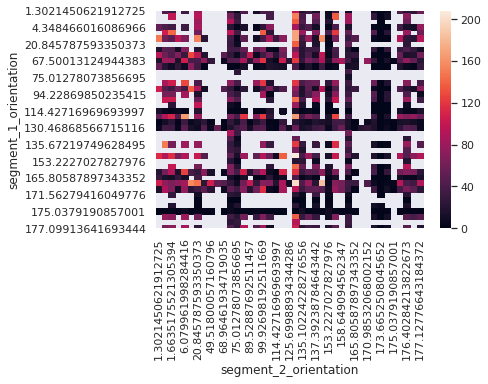

In [48]:
sns.heatmap(df)

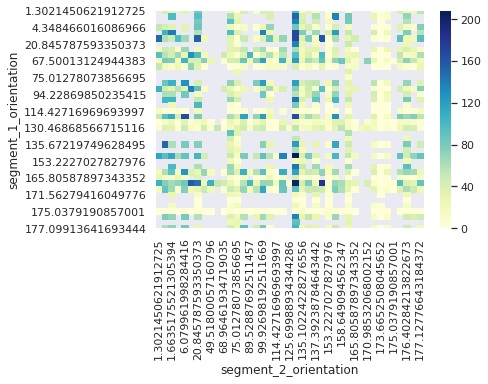

In [49]:
sns.heatmap(df, cmap="YlGnBu")

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
tips = sns.load_dataset("tips")
ax = sns.scatterplot(x="total_bill", y="tip", data=tips)

In [ ]:
ax = sns.scatterplot(x="total_bill", y="tip", hue="time",data=tips)